15.12.2021

Load a bunch of UNet predictions in folder `trainings_validation` and compute some metrics, plots, etc.

Predictions are saved as:
`{training_name}_{epoch}_{video_id}_{class}.tif`

**Idea**: Use predictions to produce plots and tables to visualize the results.

In [4]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import glob
import os
import imageio
from collections import defaultdict
import pprint

from scipy.ndimage.morphology import binary_dilation, binary_erosion
from sklearn.metrics import jaccard_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt

import unet
from metrics_tools import (correspondences_precision_recall, 
                           Metrics, 
                           reduce_metrics, 
                           empty_marginal_frames,
                           process_spark_prediction,
                           process_puff_prediction,
                           process_wave_prediction,
                           jaccard_score_exclusion_zone,
                           write_videos_on_disk,
                           get_sparks_locations_from_mask,
                           compute_prec_rec,
                           reduce_metrics_thresholds
                          )

In [2]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Select predictions to load

In [3]:
training_names = [#"256_long_chunks_ubelix",
                  "focal_loss_gamma_5_ubelix"
                  ]

epoch = 100000

### Configure input/output folder

In [4]:
metrics_folder = "trainings_validation"

### Load annotations
open and process annotations (original version, sparks not processed)


In [5]:
ys_all_trainings = {}

ys_filenames = sorted(glob.glob(os.path.join(metrics_folder, "[0-9]*_video_mask.tif")))

for f in ys_filenames:
    video_id = os.path.split(f)[1][:2]
    ys_all_trainings[video_id] = np.asarray(imageio.volread(f)).astype('int')

In [6]:
ys_all_trainings.keys()

dict_keys(['05', '10', '15', '20', '25', '32', '34', '40', '45'])

### Load predictions

In [7]:
ys = {} # contains annotations for each training
sparks = {} # contains sparks for each training
puffs = {} # contains puffs for each training
waves = {} # contains waves for each training

for training_name in training_names:
    # Import .tif files as numpy array
    base_name = os.path.join(metrics_folder,training_name+"_"+str(epoch)+"_")
    
    if training_name == "temporal_reduction": # need to use annotations from another training
        if training_names[-1] != "temporal_reduction":
            base_name_ys = os.path.join(metrics_folder,training_names[-1]+"_"+str(epoch)+"_")
            ys_filenames = sorted(glob.glob(base_name_ys+"[0-9]*_ys.tif"))
        else:
            print("SELECT TRAINING NAME DIFFERENT FROM temporal_reduction")
            break
    else:    
        ys_filenames = sorted(glob.glob(base_name+"*_ys.tif"))
        
    sparks_filenames = sorted(glob.glob(base_name+"[0-9]*_sparks.tif"))
    puffs_filenames = sorted(glob.glob(base_name+"[0-9]*_puffs.tif"))
    waves_filenames = sorted(glob.glob(base_name+"[0-9]*_waves.tif"))
        
    training_ys = {}
    training_sparks = {}
    training_puffs = {}
    training_waves = {}
    
    for idx,y,s,p,w in zip(ys_all_trainings.keys(),ys_filenames,sparks_filenames,puffs_filenames,waves_filenames):
        ys_loaded = np.asarray(imageio.volread(y)).astype('int')
        training_ys[idx] = ys_loaded
        
        if training_name == "temporal_reduction": # repeat each frame 4 times
            s_preds = np.asarray(imageio.volread(s))
            p_preds = np.asarray(imageio.volread(p))
            w_preds = np.asarray(imageio.volread(w))
                        
            # repeat predicted frames x4
            s_preds = np.repeat(s_preds,4,0)
            p_preds = np.repeat(p_preds,4,0)
            w_preds = np.repeat(w_preds,4,0)
            
            # if original length %4 != 0, crop preds
            if ys_loaded.shape != s_preds.shape:
                duration = ys_loaded.shape[0]
                s_preds = s_preds[:duration]
                p_preds = p_preds[:duration]
                w_preds = w_preds[:duration]
            
            assert ys_loaded.shape == s_preds.shape
            assert ys_loaded.shape == p_preds.shape
            assert ys_loaded.shape == w_preds.shape
            
            training_sparks[idx] = s_preds
            training_puffs[idx] = p_preds
            training_waves[idx] = w_preds
        else:
            training_sparks[idx] = np.asarray(imageio.volread(s))
            training_puffs[idx] = np.asarray(imageio.volread(p))
            training_waves[idx] = np.asarray(imageio.volread(w))

    ys[training_name] = training_ys
    sparks[training_name] = training_sparks
    puffs[training_name] = training_puffs
    waves[training_name] = training_waves       

## Jaccard index for puffs and waves
12.05.2021
Seguendo il consiglio di Pablo:
erosion & dilation delle annotations -> creazione di una exclusion region che viene ignorata dal supporto del Jaccard index

In [78]:
# Define function

'''def jaccard_score_exclusion_zone(ys,preds,exclusion_radius,ignore_mask=None,sparks=False):
    
    # Compute intersection and union
    intersection = np.logical_and(ys, preds)
    union = np.logical_or(ys, preds)
    
    if exclusion_radius != 0:
        # Compute exclusion zone: 1 where Jaccard index has to be computed, 0 otherwise
        dilated = binary_dilation(ys, iterations=exclusion_radius)
        
        if not sparks:
            eroded = binary_erosion(ys, iterations=exclusion_radius)
            exclusion_mask = 1 - np.logical_xor(eroded,dilated)
        else:
            # Erosion is not computed for spark class
            exclusion_mask = 1 - np.logical_xor(ys,dilated)
        
        # If ignore mask is given, don't compute values where it is 1
        if ignore_mask is not None:
            # Compute dilation for ignore mask too (erosion not necessary)
            ignore_mask = binary_dilation(ignore_mask, iterations=exclusion_radius)
            
            # Ignore regions where ignore mask is 1
            exclusion_mask = np.logical_and(1 - ignore_mask, exclusion_mask)
        
        # Compute intersecion of exclusion mask with intersection and union
        intersection = np.logical_and(intersection, exclusion_mask)
        union = np.logical_and(union, exclusion_mask)    
        
    #print("Pixels in intersection:", np.count_nonzero(intersection))
    #print("Pixels in union:", np.count_nonzero(union))
        
    if np.count_nonzero(union) != 0:
        iou = np.count_nonzero(intersection)/np.count_nonzero(union)
    else:
        iou = 1.
    
    return iou''';

## Compute metrics for sample video

In [12]:
# results for a sample movie in sample dataset
name = "256_long_chunks_64_step_physio"
idx = 0

In [13]:
ignore_frames = 6

### Get binary preds and remove ignored frames

In [14]:
# get predictions
sparks_sample = sparks[name][idx]
puffs_sample = puffs[name][idx]
waves_sample = waves[name][idx]

KeyError: '256_long_chunks_64_step_physio'

In [ ]:
t_detection = 0.5
min_radius_puffs = 4
min_radius_waves = 10

puffs_binary = process_puff_prediction(puffs_sample, 
                                       t_detection, 
                                       min_radius_puffs, 
                                       ignore_frames)

waves_binary = process_wave_prediction(waves_sample, 
                                       t_detection, 
                                       min_radius_waves, 
                                       ignore_frames)

### Get binary ys and remove ignored frames

In [ ]:
# get binary ys
ys_sample = ys_all_trainings[idx]

ys_puffs_sample = np.where(ys_sample==3,1,0)
ys_waves_sample = np.where(ys_sample==2,1,0)
ignore_mask = np.where(ys_sample==4,1,0)

In [ ]:
ys_puffs_sample = empty_marginal_frames(ys_puffs_sample, ignore_frames)
ys_waves_sample = empty_marginal_frames(ys_waves_sample, ignore_frames)
ignore_mask = empty_marginal_frames(ignore_mask, ignore_frames)

### Plot a sample frame

In [ ]:
sparks_sample.shape, puffs_sample.shape, waves_sample.shape, ys_sample.shape

In [ ]:
sample_frame = 199 # 346

In [ ]:
# Plot annotations and preds of sample frame

#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,8))
plt.suptitle(f"Annotations and preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(4,2,1)
ax.set_title("Puffs annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(4,2,2)
ax.set_title("Waves annotations")
plt.imshow(ys_waves_sample[sample_frame])

ax = plt.subplot(4,2,3)
ax.set_title("Puffs binary preds")
plt.imshow(puffs_binary[sample_frame])

ax = plt.subplot(4,2,4)
ax.set_title("Waves binary preds")
plt.imshow(waves_binary[sample_frame])

ax = plt.subplot(4,2,5)
ax.set_title("Puffs original preds")
plt.imshow(puffs_sample[sample_frame])

ax = plt.subplot(4,2,6)
ax.set_title("Waves original preds")
plt.imshow(waves_sample[sample_frame])

ax = plt.subplot(4,2,7)
ax.set_title("Ignore mask (annotations)")
plt.imshow(ignore_mask[sample_frame])


plt.show()

### Save sample binary preds on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_puffs.tif"), np.uint8(puffs_binary))
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_waves.tif"), np.uint8(waves_binary))

### Save sample annotations on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "annotations_puffs.tif"), np.uint8(ys_puffs_sample))
imageio.volwrite(os.path.join(metrics_folder, "annotations_waves.tif"), np.uint8(ys_waves_sample))

### Save ignore mask on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "ignore_mask.tif"), np.uint8(ignore_mask))

### Compute Jaccard score (without exclusion zone)

In [21]:
iou_puffs = jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())
iou_waves = jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())

print(f"Jaccard score puffs: {iou_puffs}")
print(f"Jaccard score waves: {iou_waves}")

Jaccard score puffs: 0.16206809118779245
Jaccard score waves: 0.0


C:\Users\dotti\.conda\envs\sparks\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Compute exclusion zone

exclusion_radius = 2

In [23]:
# Just for puffs
puffs_eroded = binary_erosion(ys_puffs_sample, iterations=exclusion_radius)
puffs_dilated = binary_dilation(ys_puffs_sample, iterations=exclusion_radius)

exclusion_mask = 1 - np.logical_xor(puffs_eroded, puffs_dilated)
# 1 where Jaccard index has to be computed, 0 otherwise

In [24]:
# Compute dilation for ignore mask
ignore_mask_dilated = binary_dilation(ignore_mask, iterations=exclusion_radius)

# Ignore regions in ignore mask too
exclusion_mask_ignore_roi = np.logical_and(1 - ignore_mask_dilated, exclusion_mask)

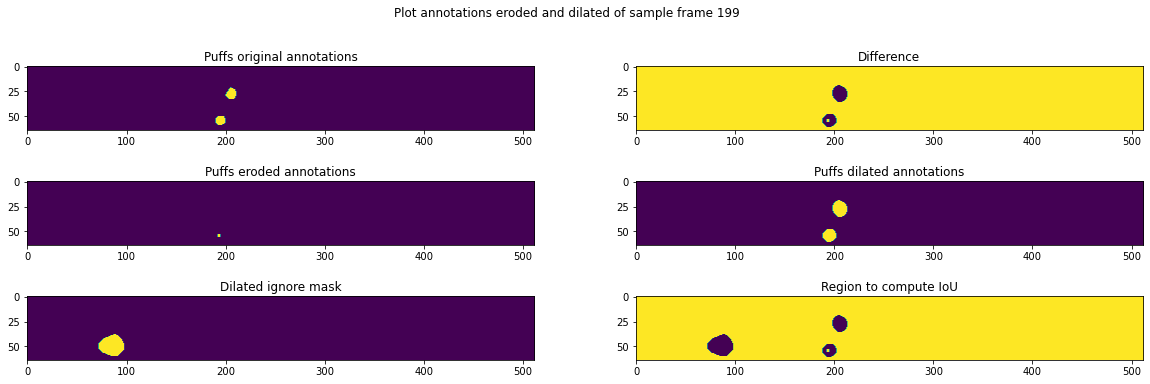

In [25]:
# Plot annotations eroded and dilated
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Plot annotations eroded and dilated of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Puffs original annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Difference")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Puffs eroded annotations")
plt.imshow(puffs_eroded[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Puffs dilated annotations")
plt.imshow(puffs_dilated[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Dilated ignore mask")
plt.imshow(ignore_mask_dilated[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Region to compute IoU")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [26]:
# Compute intersection and union of annotations with preds

intersection = np.logical_and(ys_puffs_sample, puffs_binary)
union = np.logical_or(ys_puffs_sample, puffs_binary)

# Compute intersection and union only in exclusion mask

intersection_mask = np.logical_and(intersection, exclusion_mask_ignore_roi)
union_mask = np.logical_and(union, exclusion_mask_ignore_roi)

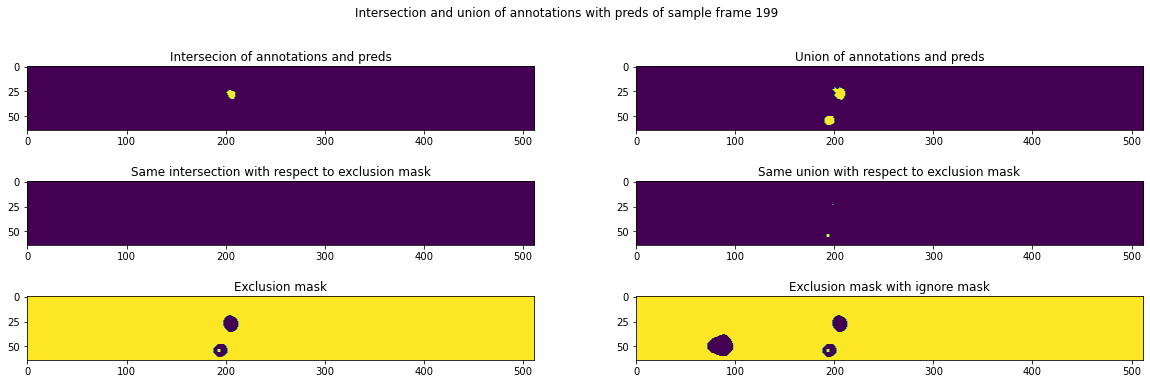

In [27]:
# Plot intersection and union
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Intersection and union of annotations with preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Intersecion of annotations and preds")
plt.imshow(intersection[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Union of annotations and preds")
plt.imshow(union[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Same intersection with respect to exclusion mask")
plt.imshow(intersection_mask[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Same union with respect to exclusion mask")
plt.imshow(union_mask[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Exclusion mask")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Exclusion mask with ignore mask")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [28]:
# Compute Jaccard index

print(f"Pixels in intersection: {np.count_nonzero(intersection_mask)}")
print(f"Pixels in union: {np.count_nonzero(union_mask)}")

new_iou_puffs = np.count_nonzero(intersection_mask)/np.count_nonzero(union_mask)

print(f"IoU wrt to wave class: {new_iou_puffs}")

Pixels in intersection: 16943
Pixels in union: 136282
IoU wrt to wave class: 0.12432309475939596


In [29]:
new_iou_puffs = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, exclusion_radius, ignore_mask)
new_iou_waves = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, exclusion_radius, ignore_mask)

In [30]:
print(new_iou_puffs)
print(new_iou_waves)

0.12432309475939596
1.0


### Jaccard index for sparks

In [73]:
# get sparks annotations
ys_sparks_sample = np.where(ys_sample==1,1,0)

# get sparks predictions
t_detection_sparks = 0.9
min_radius_sparks = 3
sparks_binary = (process_spark_prediction(sparks_sample, 
                                          t_detection=t_detection_sparks,
                                          min_radius=min_radius_sparks,
                                          ignore_frames=ignore_frames,
                                          return_clean_pred=True)) != 0 

### Comparison with original implementation (when radius = 0)

In [76]:
print("Jaccard index with new method:")
print(f"Puffs: {jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, 0)}") # ! not considering ignore mask
print(f"Waves: {jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, 0)}") # ! not considering ignore mask
print(f"Sparks: {jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, 0, sparks=True)}") # ! not considering ignore mask
print()
print("Jaccard index with sklearn metrics method")
print(f"Puffs: {jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())}")
print(f"Waves: {jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())}")
print(f"Sparks: {jaccard_score(ys_sparks_sample.ravel(), sparks_binary.ravel())}")

Jaccard index with new method:
Puffs: 0.20890103174317864
Waves: 1.0
Sparks: 0.04723618090452261

Jaccard index with sklearn metrics method
Puffs: 0.20890103174317864
Waves: 0.0
Sparks: 0.04723618090452261


### Plot IoU with respect to different exclusion radius

In [77]:
exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# puffs
ious_puffs = []
for radius in exclusion_radius_list:
    ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius)) # ! not considering ignore mask
    
# waves
ious_waves = []
for radius in exclusion_radius_list:
    ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius)) # ! not considering ignore mask
    
# sparks
ious_sparks = []
for radius in exclusion_radius_list:
    ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True)) # ! not considering ignore mask

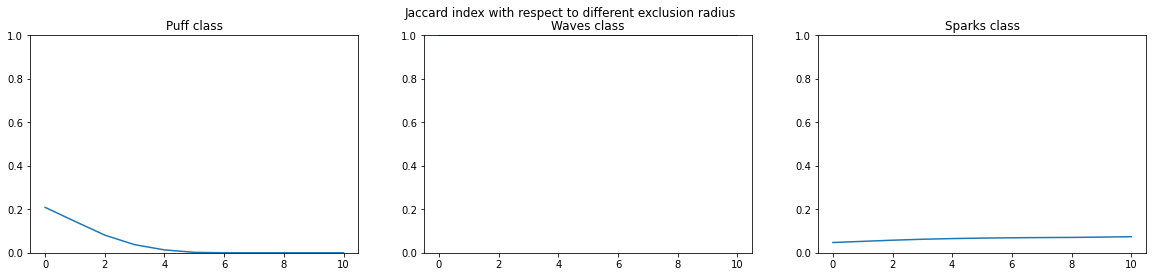

In [78]:
# Plot Jaccard index wrt different exclusion radius
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Jaccard index with respect to different exclusion radius", fontsize=12)


ax = plt.subplot(1,3,1)
ax.set_title("Puff class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_puffs)

ax = plt.subplot(1,3,2)
ax.set_title("Waves class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_waves)

ax = plt.subplot(1,3,3)
ax.set_title("Sparks class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_sparks)


plt.show()

In [79]:
print(f"IoUs puffs: {ious_puffs}")
print(f"IoUs puffs: {ious_waves}")
print(f"IoUs puffs: {ious_sparks}")

IoUs puffs: [0.20890103174317864, 0.14459408432976714, 0.08126801152737752, 0.037353441136730156, 0.013306755737528283, 0.0021321961620469083, 7.474400179385604e-05, 0.0, 0.0, 0.0, 0.0]
IoUs puffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IoUs puffs: [0.04723618090452261, 0.05264336917562724, 0.05791030064070971, 0.06230116648992577, 0.06536856745479833, 0.06762589928057554, 0.06909732431637754, 0.07004470938897168, 0.07078313253012049, 0.07219662058371736, 0.07413249211356467]


## Evaluate all trainings on all videos

In [8]:
# parameters
ignore_frames = 6
'''
t_detection = 0.5
t_detection_sparks = 0.9

min_radius_puffs = 8
min_radius_waves = 12
min_radius_sparks = 2'''

# for focal_loss_gamma_5_ubelix
# sparks params
t_detection_sparks = 0.7
min_radius_sparks = 2

# puffs and waves params
t_detection = 0.65
min_radius_puffs = 6
min_radius_waves = 8

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every training name, a list of IoU scores for all videos for all exclusion radius
ious_sparks_all_trainings = {} # num trainings x num video x num exclusion radius
ious_puffs_all_trainings = {}
ious_waves_all_trainings = {}

for training_name in training_names:
    print(training_name)
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
        
    ious_puffs_all_video = {}
    ious_waves_all_video = {}
    ious_sparks_all_video = {}
    
    for video_id in ys_all_trainings.keys():
        ys_sample = ys_all_trainings[video_id]
        sparks_sample = sparks_training[video_id]
        puffs_sample = puffs_training[video_id]
        waves_sample = waves_training[video_id]
        
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               min_radius_puffs, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               min_radius_waves, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=min_radius_sparks,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        # get ignore mask (events labelled with 4)
        ignore_mask = empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = {}
        for radius in exclusion_radius_list:
            ious_puffs[radius] = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius, ignore_mask)
            
        ious_puffs_all_video[video_id] = ious_puffs

        # waves
        ious_waves = {}
        for radius in exclusion_radius_list:
            ious_waves[radius] = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius, ignore_mask)
            
        ious_waves_all_video[video_id] = ious_waves

        # sparks
        ious_sparks = {}
        for radius in exclusion_radius_list:
            ious_sparks[radius] = jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, ignore_mask, sparks=True)
            
        ious_sparks_all_video[video_id] = ious_sparks
        
    ious_sparks_all_trainings[training_name] = ious_sparks_all_video
    ious_puffs_all_trainings[training_name] = ious_puffs_all_video
    ious_waves_all_trainings[training_name] = ious_waves_all_video

focal_loss_gamma_5_ubelix


In [9]:
pprint.pprint(ious_puffs_all_trainings)

{'focal_loss_gamma_5_ubelix': {'05': {0: 0.14759088314881752,
                                      1: 0.139164530721454,
                                      2: 0.10952007091300493,
                                      3: 0.07999067768081415,
                                      4: 0.05123214434884304,
                                      5: 0.027663039375343767,
                                      6: 0.011261883705505196,
                                      7: 0.0029556478954048367,
                                      8: 0.0003009199552918924,
                                      9: 0.0,
                                      10: 0.0},
                               '10': {0: 0.5663674907955643,
                                      1: 0.6396018813866267,
                                      2: 0.6982539775311736,
                                      3: 0.7583326657752198,
                                      4: 0.8181698381740551,
                                      5

### Compute average along videos of IoU for each exclusion radius for each training name

In [10]:
ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[training_name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name]
    
    ious_sparks_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_sparks_all_video.values()]),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_puffs_all_video.values()]),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_waves_all_video.values()]),0)/num_videos

### Plot average IoU for all trainings and all classes wrt to exclusion radius

In [11]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_sparks_avg.values(),
        *ious_puffs_avg.values(),
        *ious_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [12]:
display(df)

,Exclusion radius,0,1,2,3,4,5,6,7,8,9,10
Class,Training name,,,,,,,,,,,
Sparks,focal_loss_gamma_5_ubelix,0.078807,0.038895,0.001854,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
Puffs,focal_loss_gamma_5_ubelix,0.307429,0.319847,0.325536,0.328700,0.329287,0.327901,0.324931,0.320589,0.315353,0.309145,0.30330
Waves,focal_loss_gamma_5_ubelix,0.788636,0.800115,0.802833,0.805084,0.806883,0.808389,0.809572,0.810546,0.811265,0.811798,0.81208


In [13]:
df.to_csv("average_IoU_all_trainings_excl_radius.csv")

Text(0.5, 0, 'Exclusion radius')

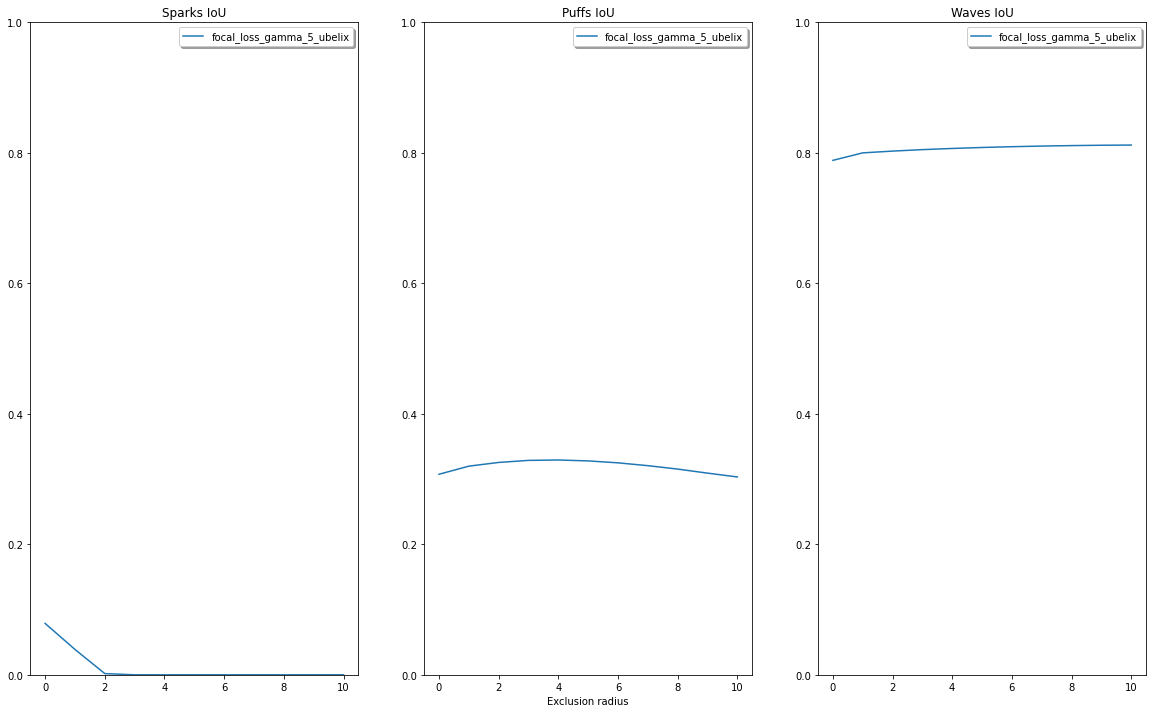

In [14]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_name], label=training_name)
           
axs[0].set_title('Sparks IoU')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_name], label=training_name)

axs[1].set_title('Puffs IoU')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[2].plot(exclusion_radius_list, ious_waves_avg[training_name], label=training_name)

axs[2].set_title('Waves IoU')
axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

In [15]:
fig.savefig("average_IoU_all_trainings_excl_radius.png")

## Plot average IoU for different minimal event radius (just for one training)

In [38]:
# set sample training
training_name = training_names[0]

# parameters
ignore_frames = 6

t_detection = 0.5
t_detection_sparks = 0.9

min_radius = [0,1,2,3,4]#,5,6,7,8,9,10]

exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# each dictionary contains, for every minimal event radius, a list of IoU scores averaged on all videos for all exclusion radius
ious_sparks_all_radius = {} # num min event radius x num ious_sparks_avg_radiususion radius
ious_puffs_all_radius = {}
ious_waves_all_radius = {}

for r in min_radius:
    # get predictions
    sparks_training = sparks[training_name]
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    ious_puffs_all_video = []
    ious_waves_all_video = []
    ious_sparks_all_video = []
    
    for sparks_sample, puffs_sample, waves_sample, ys_sample in zip(sparks_training, puffs_training, waves_training, ys_all_trainings):
        # get binary predictions and remove ignored frames
        puffs_binary = process_puff_prediction(puffs_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        waves_binary = process_wave_prediction(waves_sample, 
                                               t_detection, 
                                               r, 
                                               ignore_frames)
        sparks_binary = (process_spark_prediction(sparks_sample, 
                                                  t_detection=t_detection_sparks,
                                                  min_radius=r,
                                                  ignore_frames=ignore_frames,
                                                  return_clean_pred=True)) != 0 
        
        # get binary ys and remove ignored frames
        ys_sparks_sample = empty_marginal_frames(np.where(ys_sample==1,1,0), ignore_frames)
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        
        # get ignore regions during training
        ignore_mask =  empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        
        # compute IoU for some exclusion radius values
        # puffs
        ious_puffs = []
        for radius in exclusion_radius_list:
            ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius, ignore_mask))
            
        ious_puffs_all_video.append(ious_puffs)

        # waves
        ious_waves = []
        for radius in exclusion_radius_list:
            ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius, ignore_mask))
            
        ious_waves_all_video.append(ious_waves)

        # sparks
        ious_sparks = []
        for radius in exclusion_radius_list:
            ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, ignore_mask, sparks=True))
            
        ious_sparks_all_video.append(ious_sparks)
        
    ious_sparks_all_radius[r] = ious_sparks_all_video
    ious_puffs_all_radius[r] = ious_puffs_all_video
    ious_waves_all_radius[r] = ious_waves_all_video

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (3,1)  and requested shape (0,2)

### Compute average along videos of IoU for each exclusion radius for each minimal event radius

In [27]:
ious_sparks_avg_radius = {} # num min event radius x num exclusion radius
ious_puffs_avg_radius = {}
ious_waves_avg_radius = {}

for r in min_radius:
    num_videos = len(ious_sparks_all_radius[r])
    
    ious_sparks_all_video = ious_sparks_all_radius[r] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_radius[r] 
    ious_waves_all_video = ious_waves_all_radius[r] 
    
    ious_sparks_avg_radius[r] = np.sum(np.asarray(ious_sparks_all_video),0)/num_videos
    ious_puffs_avg_radius[r] = np.sum(np.asarray(ious_puffs_all_video),0)/num_videos
    ious_waves_avg_radius[r] = np.sum(np.asarray(ious_waves_all_video),0)/num_videos

### Plot average IoU for all minimal event radius and all classes wrt to exclusion radius

In [28]:
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, min_radius], names=['Class', 'Minimal event radius'])

data = [*ious_sparks_avg_radius.values(),
        *ious_puffs_avg_radius.values(),
        *ious_waves_avg_radius.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [29]:
display(df)

Exclusion radius                   0         1         2         3         4   \
Class  Minimal event radius                                                     
Sparks 0                     0.116289  0.121549  0.124016  0.125769  0.126827   
       1                     0.116353  0.121615  0.124085  0.125840  0.126898   
       2                     0.116751  0.122073  0.124606  0.126406  0.127487   
       3                     0.103926  0.108681  0.110933  0.112574  0.113627   
       4                     0.076986  0.080729  0.082704  0.084224  0.085273   
Puffs  0                     0.195051  0.205668  0.210015  0.212122  0.213422   
       1                     0.195059  0.205676  0.210027  0.212133  0.213432   
       2                     0.195131  0.205738  0.210082  0.212183  0.213470   
       3                     0.195202  0.205803  0.210151  0.212229  0.213474   
       4                     0.195353  0.205897  0.210204  0.212282  0.213591   
Waves  0                     0.787339  0.799457  0.802117  0.804287  0.806003   
       1                     0.787339  0.799457  0.802117  0.804288  0.806003   
       2                     0.787344  0.799462  0.802123  0.804294  0.806010   
       3                     0.787349  0.799467  0.802127  0.804299  0.806015   
       4                     0.787358  0.799477  0.802138  0.804309  0.806025   

Exclusion radius                   5         6         7         8         9   \
Class  Minimal event radius                                                     
Sparks 0                     0.127459  0.127829  0.128049  0.128149  0.128194   
       1                     0.127530  0.127900  0.128119  0.128220  0.128264   
       2                     0.128136  0.128517  0.128742  0.128843  0.128886   
       3                     0.114285  0.114670  0.114889  0.114978  0.115004   
       4                     0.085928  0.086289  0.086464  0.086526  0.086543   
Puffs  0                     0.215477  0.218401  0.221077  0.223142  0.224177   
       1                     0.215484  0.218405  0.221079  0.223143  0.224178   
       2                     0.215500  0.218409  0.221071  0.223128  0.224159   
       3                     0.215464  0.218364  0.221037  0.223125  0.224159   
       4                     0.215688  0.218741  0.221614  0.223923  0.225162   
Waves  0                     0.807289  0.808214  0.808830  0.809212  0.809271   
       1                     0.807289  0.808214  0.808831  0.809213  0.809273   
       2                     0.807297  0.808223  0.808841  0.809224  0.809285   
       3                     0.807302  0.808228  0.808846  0.809229  0.809289   
       4                     0.807312  0.808238  0.808856  0.809239  0.809299   

Exclusion radius                   10  
Class  Minimal event radius            
Sparks 0                     0.128251  
       1                     0.128320  
       2                     0.128937  
       3                     0.115034  
       4                     0.086592  
Puffs  0                     0.223890  
       1                     0.223891  
       2                     0.223877  
       3                     0.223877  
       4                     0.225099  
Waves  0                     0.808954  
       1                     0.808955  
       2                     0.808968  
       3                     0.808972  
       4                     0.808982

In [30]:
df.to_csv("average_IoU_different_min_event_size_excl_radius.csv")

Text(0.5, 0, 'Exclusion radius')

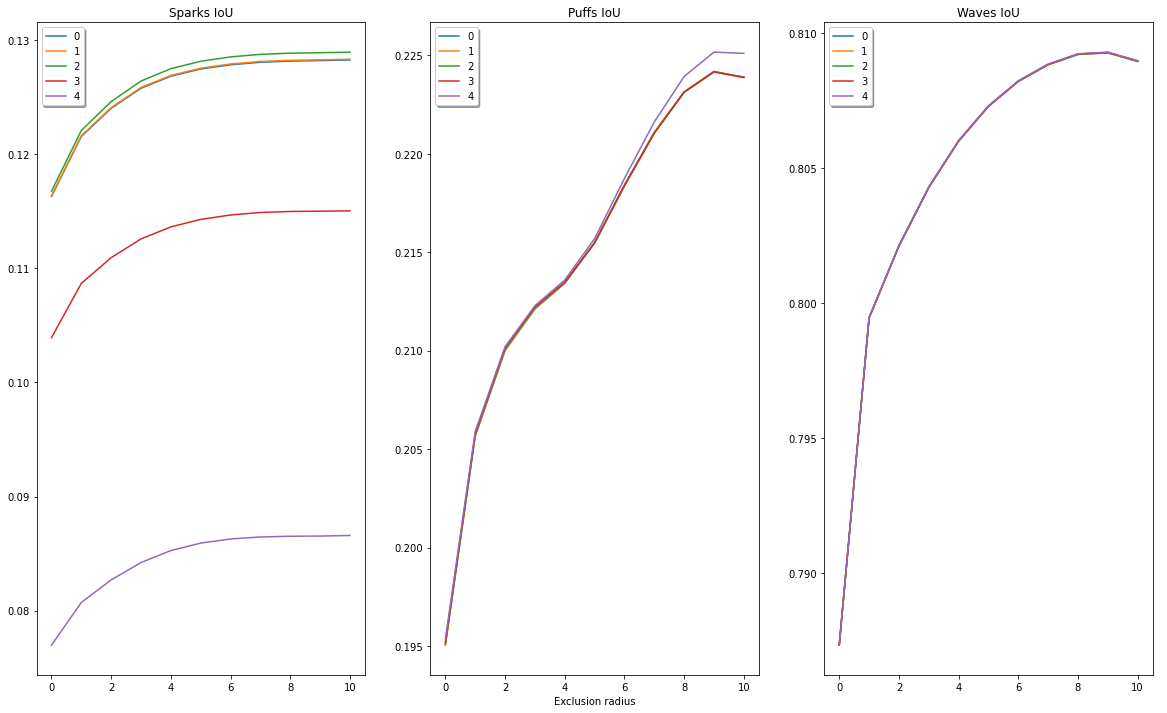

In [31]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for r in min_radius:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg_radius[r], label=r)
           
axs[0].set_title('Sparks IoU')
#axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg_radius[r], label=r)

axs[1].set_title('Puffs IoU')
#axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for r in min_radius:
    axs[2].plot(exclusion_radius_list, ious_waves_avg_radius[r], label=r)

axs[2].set_title('Waves IoU')
#axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

In [32]:
fig.savefig("average_IoU_different_min_event_size_excl_radius.png")

## Sparks metrics (TODO)

In [16]:
from metrics_tools import nonmaxima_suppression

def compute_prec_rec(annotations, preds, thresholds, ignore_frames=0,
                     min_radius=3, match_distance=6, ignore_mask=None):
    # annotations: video of sparks segmentation w/ values in {0,1}
    # preds: video of sparks preds w/ values in [0,1]
    # thresholds : list of thresholds applied to the preds over which events are kept
    # min_radius : minimal "radius" of a valid event
    # match_distance : maximal distance between annotation and pred
    # ignore_mask: binary mask indicating where to ignore the values
    # returns a list of Metrics tuples corresponding to thresholds and AUC

    if ignore_frames != 0:
        annotations = empty_marginal_frames(annotations, ignore_frames)
        preds = empty_marginal_frames(preds, ignore_frames)
    
    # if using an ignore mask, remove predictions inside ignore regions
    if ignore_mask is not None:
        preds = preds * (1 - ignore_mask)

    metrics = {} # list of 'Metrics' tuples: precision, recall, tp, tp_fp, tp_fn
                 # indexed by threshold value

    coords_true = nonmaxima_suppression(annotations)

    # compute prec and rec for every threshold
    for t in thresholds:
        coords_preds = process_spark_prediction(preds,
                                                t_detection=t,
                                                min_radius=min_radius)

        prec_rec = Metrics(*correspondences_precision_recall(coords_true,
                                                             coords_preds,
                                                             match_distance))

        metrics[t] = prec_rec
        #print("threshold", t)
        #prec.append(prec_rec.precision)
        #rec.append(prec_rec.recall)


    # compute AUC for this sample
    #area_under_curve = auc(rec, prec)

    return metrics#, area_under_curve

def reduce_metrics_thresholds(results):
    # apply metrics reduction to results corresponding to different thresholds
    # results is a dict of dicts (# videos x # thresholds)
    # thresholds is the list of used thresholds
    # returns dicts of reduced 'Metrics' instances for every threshold (# thresholds x # metrics)

    # revert nested dictionaires 
    results_t = defaultdict(dict)
    for video_id, video_metrics in results.items():
        for t, t_metrics in video_metrics.items():
            results_t[t][video_id] = t_metrics

    reduced_metrics = {}
    prec = {}
    rec = {}

    for t, res in results_t.items():
        # res is a dict of 'Metrics' for all videos
        reduced_res = reduce_metrics(list(res.values()))

        reduced_metrics[t] = reduced_res
        prec[t] = reduced_res.precision
        rec[t] = reduced_res.recall

    # compute area under the curve for reduced metrics
    #print("REC",rec)
    #print("PREC",prec)
    #area_under_curve = roc_auc_score(rec, prec)
    #print("AREA UNDER CURVE", area_under_curve)

    return reduced_metrics, prec, rec, None

In [24]:
# parameters
ignore_frames = 6

t_detection_sparks = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

min_radius_sparks = 2
match_distance = 6

# each dictionary contains, for every training name, a list of prec rec scores for all videos for all thresholds
prec_rec_sparks_all_trainings = {} # num trainings x num video x num thresholds

for training_name in training_names:
    print(training_name)
    # get predictions
    sparks_training = sparks[training_name]
    
    # get annotations
    ys_training = ys[training_name]
    
    prec_rec_sparks_all_video = {}
    
    for video_id in ys_all_trainings.keys():
        print(video_id)
        sparks_sample = sparks_training[video_id]
        ys_sample = ys_training[video_id]
        ys_raw = ys_all_trainings[video_id]
        
        # get binary ys 
        ys_sparks_sample = np.where(ys_sample==1,1.0,0.0)
        
        # get ignore mask
        ignore_mask =  np.where(ys_raw==4,1,0)
            
        # compute precision and recall for some thresholds and remove ignored frames
        prec_rec_all_t = compute_prec_rec(ys_sparks_sample, sparks_sample, 
                                          t_detection_sparks, ignore_frames,
                                          min_radius_sparks, match_distance,
                                          ignore_mask
                                         ) # dict indexed by threshold value
        pprint.pprint(dict(prec_rec_all_t))
        prec_rec_sparks_all_video[video_id] = prec_rec_all_t
        
    prec_rec_sparks_all_trainings[training_name] = prec_rec_sparks_all_video

focal_loss_gamma_5_ubelix
05
{0.5: Metrics(precision=0.19487179487179487, recall=0.5428571428571428, tp=38, tp_fp=195, tp_fn=70),
 0.55: Metrics(precision=0.21468926553672316, recall=0.5428571428571428, tp=38, tp_fp=177, tp_fn=70),
 0.6: Metrics(precision=0.21875, recall=0.5, tp=35, tp_fp=160, tp_fn=70),
 0.65: Metrics(precision=0.22535211267605634, recall=0.45714285714285713, tp=32, tp_fp=142, tp_fn=70),
 0.7: Metrics(precision=0.24603174603174602, recall=0.44285714285714284, tp=31, tp_fp=126, tp_fn=70),
 0.75: Metrics(precision=0.2978723404255319, recall=0.4, tp=28, tp_fp=94, tp_fn=70),
 0.8: Metrics(precision=0.4, recall=0.2571428571428571, tp=18, tp_fp=45, tp_fn=70),
 0.85: Metrics(precision=0.6666666666666666, recall=0.08571428571428572, tp=6, tp_fp=9, tp_fn=70),
 0.9: Metrics(precision=1.0, recall=0.014285714285714285, tp=1, tp_fp=1, tp_fn=70),
 0.95: Metrics(precision=1.0, recall=0.0, tp=0, tp_fp=0, tp_fn=70)}
10
{0.5: Metrics(precision=0.09782608695652174, recall=0.45, tp=9, tp

### Average over all videos

In [25]:
prec_rec_sparks_avg = {} # num training x num thresholds
prec_avg = {}
rec_avg = {}

for training_name in training_names:
    prec_rec_all_videos = prec_rec_sparks_all_trainings[training_name]
    prec_rec_sparks_avg[training_name] = reduce_metrics_thresholds(prec_rec_all_videos)
    prec_avg[training_name] = prec_rec_sparks_avg[training_name][1]
    rec_avg[training_name] = prec_rec_sparks_avg[training_name][2]

### Dataframe and plots of results

In [26]:
cols = pd.Index(t_detection_sparks, name='Detection threshold')
metrics = ['Precision', 'Recall']
rows = pd.MultiIndex.from_product([metrics, training_names], names=['Class', 'Training name'])

data = [*prec_avg.values(),
        *rec_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [27]:
display(df)

,Detection threshold,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
Class,Training name,,,,,,,,,,
Precision,focal_loss_gamma_5_ubelix,0.118196,0.143689,0.175060,0.212798,0.250000,0.320475,0.400000,0.666667,1.000000,1.0
Recall,focal_loss_gamma_5_ubelix,0.582375,0.567050,0.559387,0.547893,0.482759,0.413793,0.222222,0.030651,0.003831,0.0


In [28]:
df.to_csv("sparks_precision_recall.csv")

Text(0.5, 0, 'Detection threshold')

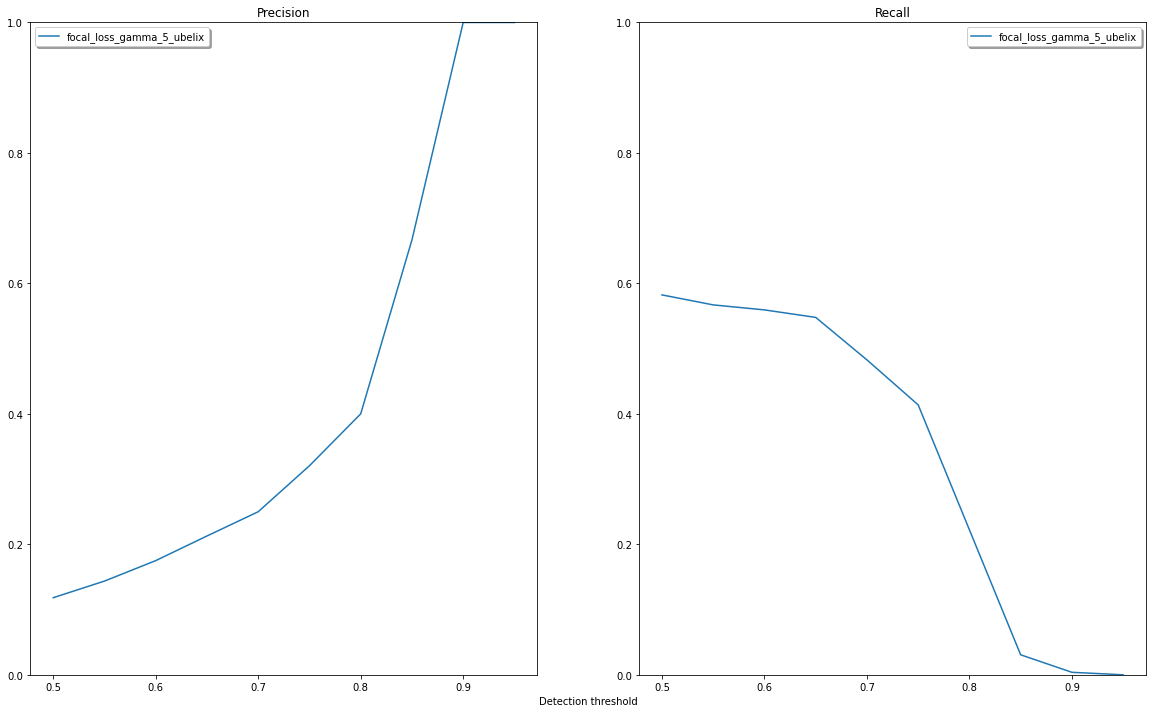

In [29]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(t_detection_sparks, prec_avg[training_name].values(), label=training_name)
           
axs[0].set_title('Precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(t_detection_sparks, rec_avg[training_name].values(), label=training_name)

axs[1].set_title('Recall')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Detection threshold")

In [30]:
fig.savefig("sparks_precision_recall.png")